- Use Clothing, Shoes and Jewelry dataset (file Clothing_Shoes_and_Jewelry_5.json in reviews_Clothing_Shoes_and_Jewelry_5.json.gz) to build a model to predict customer sentiment (You can categories into 3 groups such as like: 4 or 5 stars, dislike: 1 or 2 stars, neutral :3 stars; or categories into 2 groups...) (**overall** column) based on their review (**reviewText** column)
- Read more information here: http://jmcauley.ucsd.edu/data/amazon/

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np

In [2]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [4]:
%cd '/content/gdrive/MyDrive/DATA SCIENCE - ĐH KHTN/LDS8 - Deep Learning/FinalTest'
# %cd '/content/gdrive/MyDrive/Deep Learning'

/content/gdrive/MyDrive/DATA SCIENCE - ĐH KHTN/LDS8 - Deep Learning/FinalTest


In [5]:
# load dataset
df = pd.read_json('Data/Clothing_Shoes_and_Jewelry_5.json', lines=True)
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",This is a great tutu and at a really great pri...,5,Great tutu- not cheaply made,1297468800,"02 12, 2011"
1,A2G5TCU2WDFZ65,0000031887,Amazon Customer,"[0, 0]",I bought this for my 4 yr old daughter for dan...,5,Very Cute!!,1358553600,"01 19, 2013"
2,A1RLQXYNCMWRWN,0000031887,Carola,"[0, 0]",What can I say... my daughters have it in oran...,5,I have buy more than one,1357257600,"01 4, 2013"
3,A8U3FAMSJVHS5,0000031887,Caromcg,"[0, 0]","We bought several tutus at once, and they are ...",5,"Adorable, Sturdy",1398556800,"04 27, 2014"
4,A3GEOILWLK86XM,0000031887,CJ,"[0, 0]",Thank you Halo Heaven great product for Little...,5,Grammy's Angels Love it,1394841600,"03 15, 2014"


In [6]:
data = df[['reviewText','overall']]
data.head()

,reviewText,overall
0,This is a great tutu and at a really great pri...,5
1,I bought this for my 4 yr old daughter for dan...,5
2,What can I say... my daughters have it in oran...,5
3,"We bought several tutus at once, and they are ...",5
4,Thank you Halo Heaven great product for Little...,5


#### Note:
* Chia thành 2 nhóm đối với bài toán này: like: 4 or 5 stars, dislike: 1 or 2 stars

In [7]:
map_lst = {1: 'dislike', 2:'dislike', 4:'like', 5:'like'}
data = data.replace({"overall": map_lst})
data.head()

,reviewText,overall
0,This is a great tutu and at a really great pri...,like
1,I bought this for my 4 yr old daughter for dan...,like
2,What can I say... my daughters have it in oran...,like
3,"We bought several tutus at once, and they are ...",like
4,Thank you Halo Heaven great product for Little...,like


In [8]:
data = data.drop(data[data.overall == 3].index)

In [9]:
data['overall'].value_counts()
# dữ liệu không cân bằng

like       221597
dislike     26655
Name: overall, dtype: int64

In [10]:
map_output = {'dislike':0, 'like':1}
data = data.replace({"overall": map_output})
data['overall'].value_counts()

1    221597
0     26655
Name: overall, dtype: int64

## Tiền xử lý dữ liệu

In [11]:
# Check for missing values
print(data.isnull().sum())

reviewText    0
overall       0
dtype: int64


In [12]:
# Count the number of words in each comment.
data['WORDS'] = data['reviewText'].apply(lambda x: len(x.split()))
data['WORDS'].describe()

count    248252.000000
mean         59.385423
std          60.252893
min           0.000000
25%          26.000000
50%          40.000000
75%          69.000000
max        2158.000000
Name: WORDS, dtype: float64

<Axes: >

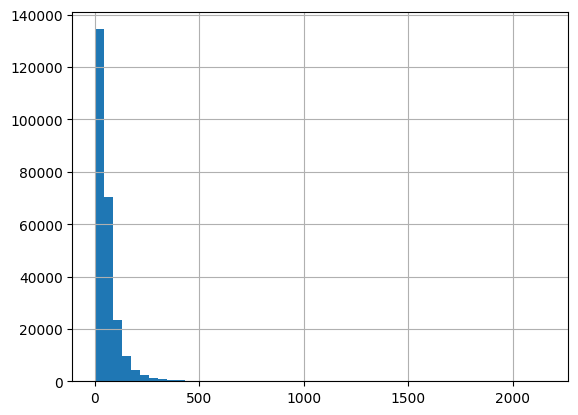

In [13]:
# Plot a histogram of the number of words in each comment.
data['WORDS'].hist(bins=50)

overall
0    Axes(0.125,0.11;0.775x0.77)
1    Axes(0.125,0.11;0.775x0.77)
Name: WORDS, dtype: object

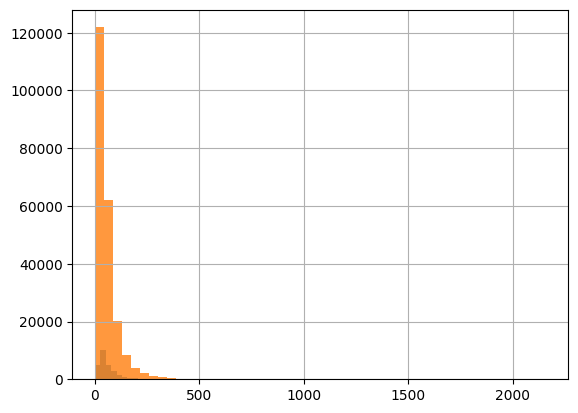

In [14]:
# Grouping by class, and plot the histograms.
data.groupby('overall')['WORDS'].hist(bins=50, alpha=0.8)

**Nhận xét:**
* Có chênh lệch lớn trong số lượng chữ trung bình của review trong 2 class

### Text Preprocessing

In [15]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [16]:
def preprocess(text, stem=False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [17]:
data.reviewText = data.reviewText.apply(lambda x: preprocess(x))

In [18]:
data.head()

,reviewText,overall,WORDS
0,great tutu really great price look cheap glad ...,1,35
1,bought 4 yr old daughter dance class wore toda...,1,61
2,say daughters orange black white pink thinking...,1,62
3,bought several tutus got high reviews sturdy s...,1,76
4,thank halo heaven great product little girls g...,1,80


### Process the data

* Tokenize the text into sequences.
* Pad the sequences to the same length. Based on the histograms, `100` seems to be a good length.

In [19]:
# Split the data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(data['reviewText'], data['overall'], random_state=42, test_size=0.2)

In [20]:
max_len = 100
max_words = 1000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_words)

In [21]:
tokenizer.fit_on_texts(X_train)

In [22]:
# Num of unique words
tokenizer.num_words

1000

In [23]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [24]:
X_train_pad = tf.keras.preprocessing.sequence.pad_sequences(X_train_seq, maxlen=max_len, padding='pre', truncating='post')
X_test_pad = tf.keras.preprocessing.sequence.pad_sequences(X_test_seq, maxlen=max_len, padding='pre', truncating='post')

In [25]:
# Print the shapes of the data.
print(f'X_train shape: {X_train_pad.shape}')
print(f'X_test shape: {X_test_pad.shape}')

X_train shape: (198601, 100)
X_test shape: (49651, 100)


In [26]:
# Print some example padded sequences.
print(X_train_pad[100, :])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  11 344  13
  26 146 158 146  10 126   1  20  53  20]


## Build an LSTM model

In [27]:
model = tf.keras.Sequential([
    # Add an Embedding layer to convert integer values to word embeddings.
    tf.keras.layers.Embedding(output_dim=50, input_length=max_len, input_dim=tokenizer.num_words),
    # Add a LSTM layer with 128 internal units.
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32),


    # Add a Dense layer
    tf.keras.layers.Dense(units=256, activation='relu'),
    # Add a Dropout layer to prevent overfitting.
    tf.keras.layers.Dropout(rate=0.3),

    # Add a Dense layer
    tf.keras.layers.Dense(units=128, activation='relu'),
    # Add a Dropout layer to prevent overfitting.
    tf.keras.layers.Dropout(rate=0.3),


    # Add the output layer.
    tf.keras.layers.Dense(units=1, activation='sigmoid')    # We can use 1 unit with sigmoid activation and binary_crossentropy loss.
])

In [28]:
# Compile the model.
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [29]:
# Print the model summary.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           50000     
                                                                 
 bidirectional (Bidirectiona  (None, 100, 256)         183296    
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 100, 64)           82176     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 256)               8448      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                        

In [30]:
# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [31]:
# Train the model.
history = model.fit(X_train_pad,
                    y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=[early_stopping])

Epoch 1/50
5586/5586 [==============================] - 177s 30ms/step - loss: 0.2128 - accuracy: 0.9197 - val_loss: 0.1798 - val_accuracy: 0.9278
Epoch 2/50
5586/5586 [==============================] - 119s 21ms/step - loss: 0.1722 - accuracy: 0.9332 - val_loss: 0.1661 - val_accuracy: 0.9339
Epoch 3/50
5586/5586 [==============================] - 118s 21ms/step - loss: 0.1626 - accuracy: 0.9373 - val_loss: 0.1654 - val_accuracy: 0.9363
Epoch 4/50
5586/5586 [==============================] - 119s 21ms/step - loss: 0.1549 - accuracy: 0.9407 - val_loss: 0.1690 - val_accuracy: 0.9366
Epoch 5/50
5586/5586 [==============================] - 122s 22ms/step - loss: 0.1482 - accuracy: 0.9425 - val_loss: 0.1590 - val_accuracy: 0.9388
Epoch 6/50
5586/5586 [==============================] - 116s 21ms/step - loss: 0.1420 - accuracy: 0.9459 - val_loss: 0.1591 - val_accuracy: 0.9387
Epoch 7/50
5586/5586 [==============================] - 116s 21ms/step - loss: 0.1349 - accuracy: 0.9486 - val_loss: 0

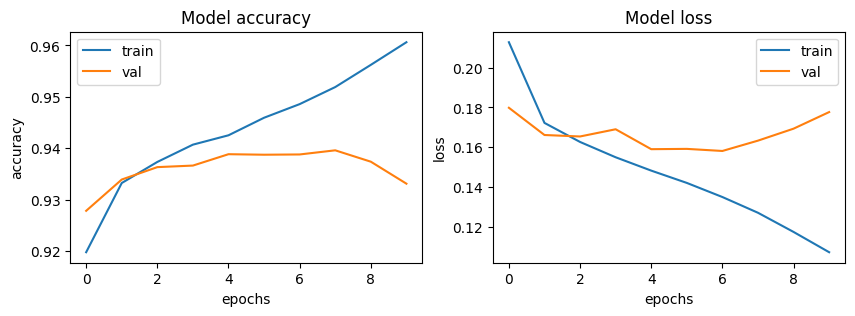

In [32]:
# Plot the loss and accuracy values achieved during training for the training and validation set.
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()
for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [33]:
# Evaluate the model on the test set.
score = model.evaluate(X_test_pad, y_test)

1552/1552 [==============================] - 14s 9ms/step - loss: 0.1510 - accuracy: 0.9424


In [34]:
print(f'Test loss: {score[0]}')

Test loss: 0.15102650225162506


In [35]:
print(f'Test accuracy: {score[1]}')

Test accuracy: 0.942418098449707


In [36]:
y_pred = model.predict(X_test_pad)

1552/1552 [==============================] - 14s 8ms/step


In [37]:
y_pred

array([[0.9999945 ],
       [0.97565186],
       [0.70056933],
       ...,
       [0.9999695 ],
       [0.9974825 ],
       [0.9919629 ]], dtype=float32)

In [38]:
def decode_sentiment(score):
    return 1 if score>0.5 else 0

y_pred_label = [decode_sentiment(score) for score in y_pred]

In [39]:
y_pred_label[:10]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 0]

### Confusion Matrix

In [40]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

In [41]:
print(classification_report(list(y_test), y_pred_label))

              precision    recall  f1-score   support

           0       0.77      0.64      0.70      5204
           1       0.96      0.98      0.97     44447

    accuracy                           0.94     49651
   macro avg       0.87      0.81      0.83     49651
weighted avg       0.94      0.94      0.94     49651



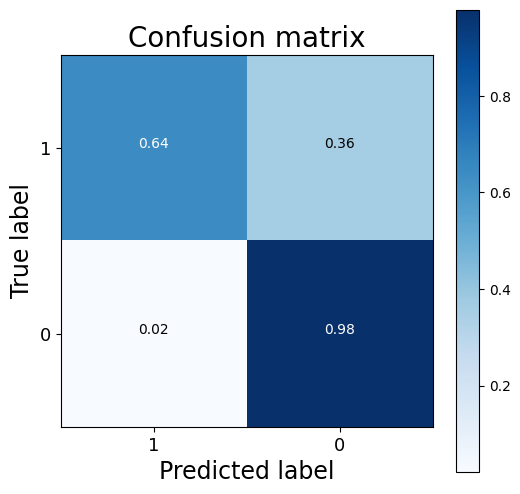

In [42]:
cnf_matrix = confusion_matrix(y_test.to_list(), y_pred_label)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=y_test.unique(), title="Confusion matrix")
plt.show()

**Nhận xét:**
* Từ kết quả trên có thể thấy mô hình có độ chính xác rất cao ~94%
* Vẫn còn hiện tượng overfitting nhưng không nhiều
* Điểm yếu của mô hình là precision và recall của class dislike có độ chính xác khá thấp so với class like, cần phải cải thiện thêm qua trong quá trình thử nghiệm mô hình